# Script - B2W Challenge - Lucas Edler

## 1) Pré processamento dos dados

Importando bibliotecas

In [1]:
comp_prices<-read.csv("comp_prices.csv", sep = ",")
sales<-read.csv("sales.csv")

Cria conceito de preço unitário

In [2]:
sales$UNITARY_PRICE<-sales$REVENUE / sales$QTY_ORDER

Tratamento de dados: tabela comp_prices parece ter erros de input (alguns dados parecem estar multiplicados *100)

In [3]:
comp_prices_aux<-comp_prices[,c("COMPETITOR_PRICE","PROD_ID","DATE_EXTRACTION","COMPETITOR", "PAY_TYPE")]
names(comp_prices_aux)<-c("UNITARY_PRICE","PROD_ID","DATE_ORDER","SELLER","PAY_TYPE")
comp_prices_aux$UNITARY_PRICE<-ifelse(comp_prices_aux$UNITARY_PRICE>3000,comp_prices_aux$UNITARY_PRICE/100,comp_prices_aux$UNITARY_PRICE)

# 2) Modelagem

Produto 2 (P2)

In [4]:
sales_P<-sales[sales$PROD_ID=="P2",c("DATE_ORDER","QTY_ORDER","UNITARY_PRICE")]

Criando matriz com dia, quantidade vendidade e preço médio de venda

In [5]:
aux<-aggregate(sales_P$UNITARY_PRICE, by = list(sales_P$DATE_ORDER), FUN = mean)
sales_P<-aggregate(sales_P$QTY_ORDER, by = list(sales_P$DATE_ORDER), FUN = sum)
sales_P<-merge(sales_P,aux,by = "Group.1", all.x = TRUE)

Enriquecendo matriz com a informação do preço mínimo da concorrência

Pay type = 1 (vendas a prazo)

In [6]:
comp_prices_P_M1<-comp_prices_aux[comp_prices_aux$PROD_ID=="P2" & comp_prices_aux$PAY_TYPE==1,c("DATE_ORDER","UNITARY_PRICE")]
comp_prices_P_M1$DATE_ORDER<-as.Date(comp_prices_P_M1$DATE_ORDER)
comp_prices_P_M1$DATE_ORDER<-as.factor(comp_prices_P_M1$DATE_ORDER)
aux<-aggregate(comp_prices_P_M1$UNITARY_PRICE, by = list(comp_prices_P_M1$DATE_ORDER), FUN = min)
sales_P<-merge(sales_P,aux,by = "Group.1", all.x = TRUE)

Pay type = 2 (vendas a vista)

In [7]:
comp_prices_P_M2<-comp_prices_aux[comp_prices_aux$PROD_ID=="P2" & comp_prices_aux$PAY_TYPE==2,c("DATE_ORDER","UNITARY_PRICE")]
comp_prices_P_M2$DATE_ORDER<-as.Date(comp_prices_P_M2$DATE_ORDER)
comp_prices_P_M2$DATE_ORDER<-as.factor(comp_prices_P_M2$DATE_ORDER)
aux<-aggregate(comp_prices_P_M2$UNITARY_PRICE, by = list(comp_prices_P_M2$DATE_ORDER), FUN = min)
sales_P<-merge(sales_P,aux,by = "Group.1", all.x = TRUE)

Warning message in merge.data.frame(sales_P, aux, by = "Group.1", all.x = TRUE):
"column names 'x.x', 'x.y' are duplicated in the result"

Renomeando colunas

In [8]:
names(sales_P)<-c("Date","QTY","P_B2W","P_Comp_M1","P_Comp_M2")

Criando indicador: delta entre preço médio B2W e preços mínimos da concorrência

In [9]:
sales_P$Diff_Price_Comp_M1<-sales_P$P_B2W / sales_P$P_Comp_M1 - 1
sales_P$Diff_Price_Comp_M2<-sales_P$P_B2W / sales_P$P_Comp_M2 - 1

Evolução das vendas

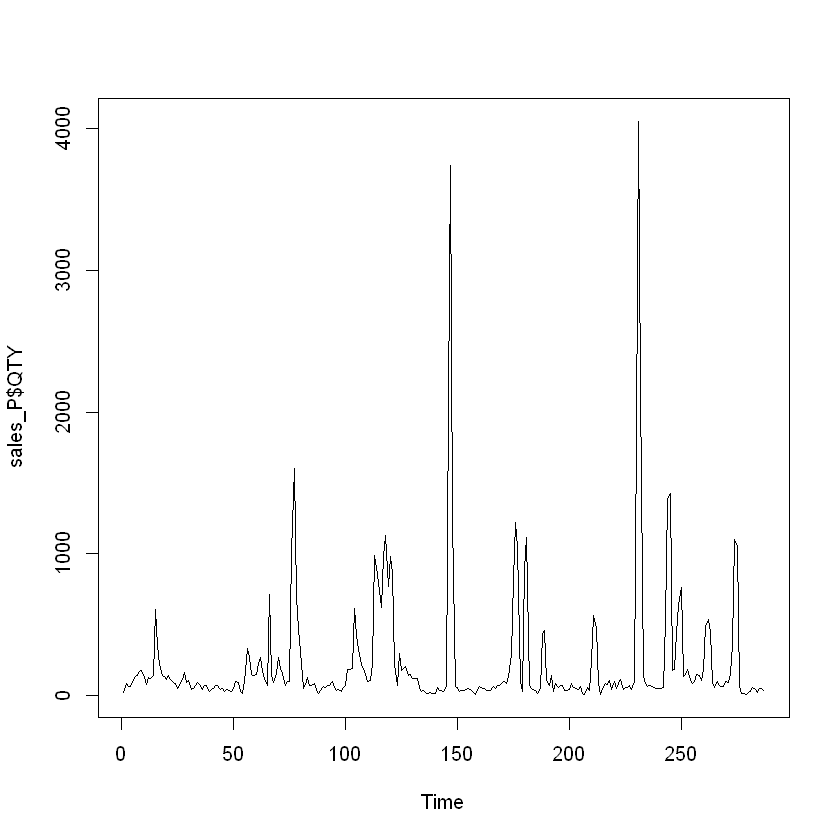

In [10]:
ts.plot(sales_P$QTY)

Comportamento da variação das vendas dia a dia (curva de vendas eliminada a tendência de longo prazo)

Podemos observar que as variações nas vendas costumam orbitar média = 0. Dado que não é possível observar uma tendência de alta ou baixa, o modelo sugere um estilo White Noise

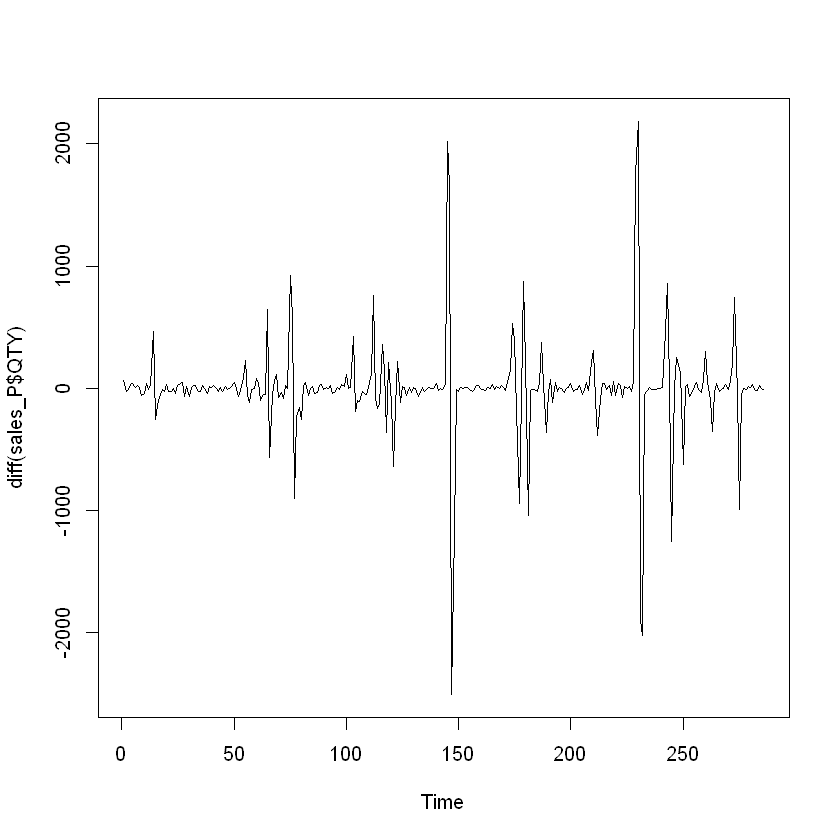

In [11]:
ts.plot(diff(sales_P$QTY))

## Análise de correlação

O produto 2 já não apresenta uma correlação tão forte com o preço quanto o produto 1

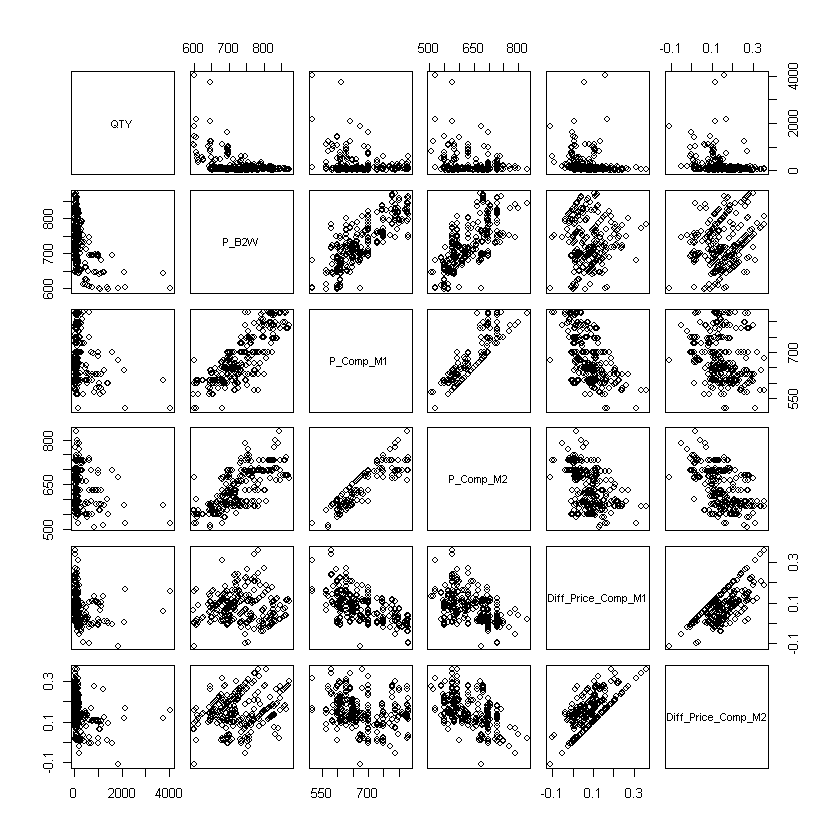

In [12]:
pairs(sales_P[,c("QTY","P_B2W","P_Comp_M1","P_Comp_M2","Diff_Price_Comp_M1","Diff_Price_Comp_M2")])

Ainda assim, um índice de correlação de -0.41 denota que há um influcência considerável do preço na curva de vendas. A influência do preço da concorrência é ainda menor que o verificado em P1

In [13]:
cor(sales_P[,c("QTY","P_B2W")])
cor(na.omit(sales_P[,c("QTY","P_Comp_M1","P_Comp_M2","Diff_Price_Comp_M1","Diff_Price_Comp_M2")]))

QTY        P_B2W     
QTY    1.0000000 -0.4132305
P_B2W -0.4132305  1.0000000

QTY        P_Comp_M1  P_Comp_M2  Diff_Price_Comp_M1
QTY                 1.0000000 -0.2297696 -0.2050281 -0.1666668        
P_Comp_M1          -0.2297696  1.0000000  0.8666054 -0.6010000        
P_Comp_M2          -0.2050281  0.8666054  1.0000000 -0.4914701        
Diff_Price_Comp_M1 -0.1666668 -0.6010000 -0.4914701  1.0000000        
Diff_Price_Comp_M2 -0.2358432 -0.2310098 -0.5183445  0.6810486        
                   Diff_Price_Comp_M2
QTY                -0.2358432        
P_Comp_M1          -0.2310098        
P_Comp_M2          -0.5183445        
Diff_Price_Comp_M1  0.6810486        
Diff_Price_Comp_M2  1.0000000

## Analise de autocorrelação

O gráfico de autocorrelação nos mostra que a autocorrelação em P2 é mais fraca que a autocorrelação em P1. Aproximando o modelo de um tipo White Noise. Apesar disso, a correlação em TN-1 é mais forte em P2 = 0.63


Autocorrelations of series 'sales_P$QTY', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000  0.629  0.142  0.000  0.002 -0.009 -0.040 -0.063 -0.073 -0.089 -0.092 

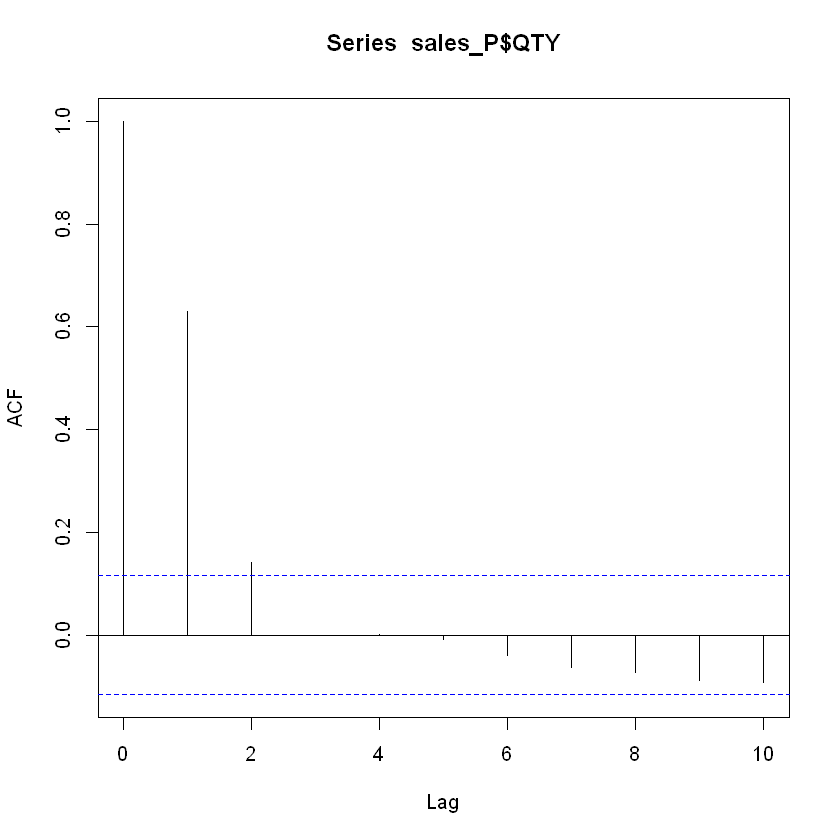

In [14]:
acf(sales_P$QTY,lag.max = 10,plot = FALSE)
acf(sales_P$QTY,lag.max = 10,plot = TRUE)

## Modelo de Autoregressão

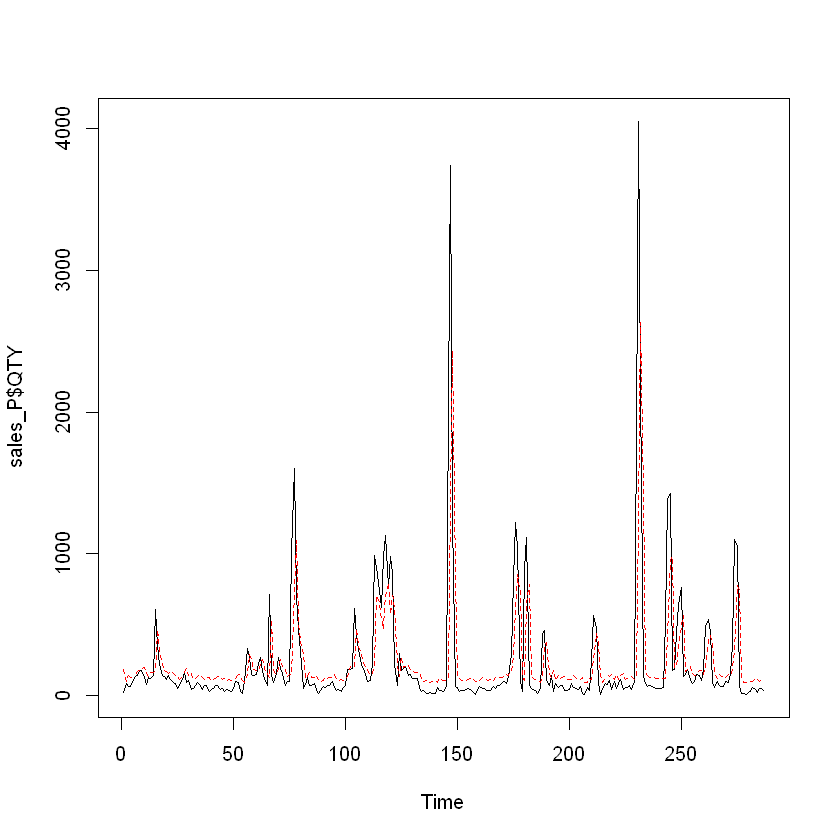

In [15]:
AR_Model<-arima(sales_P$QTY, order = c(1,0,0))
AR_fitted<-sales_P$QTY - residuals(AR_Model)
ts.plot(sales_P$QTY)
points(AR_fitted, type = "l", col = 2, lty = 2)

Realizando a previsão

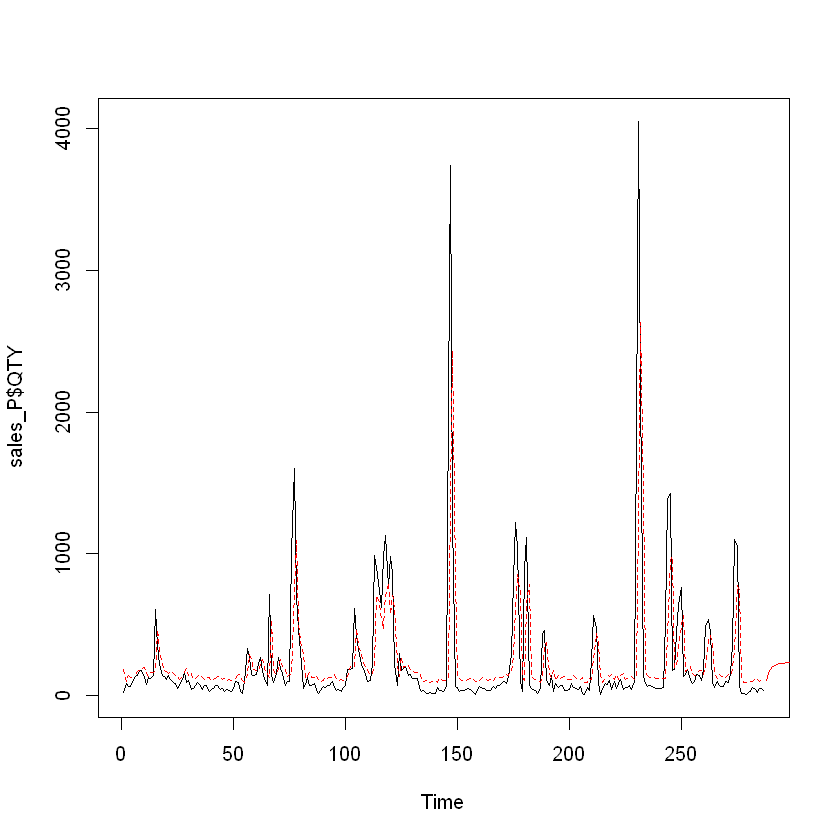

In [16]:
predict_AR<-predict(AR_Model,n.ahead = 30)
ts.plot(sales_P$QTY)
points(AR_fitted, type = "l", col = 2, lty = 2)
points(predict_AR$pred, type = "l", col = 2)

## Modelo de média móvel simples

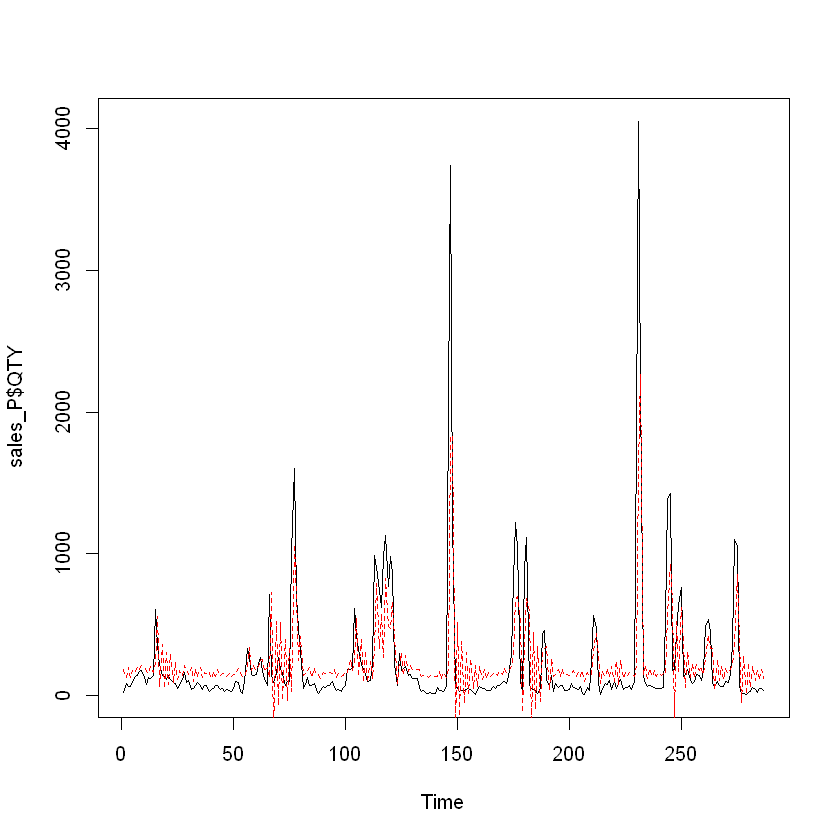

In [17]:
MA_Model<-arima(sales_P$QTY, order = c(0,0,1))
MA_fitted<-sales_P$QTY - residuals(MA_Model)
ts.plot(sales_P$QTY)
points(MA_fitted, type = "l", col = 2, lty = 2)

Realizando previsão

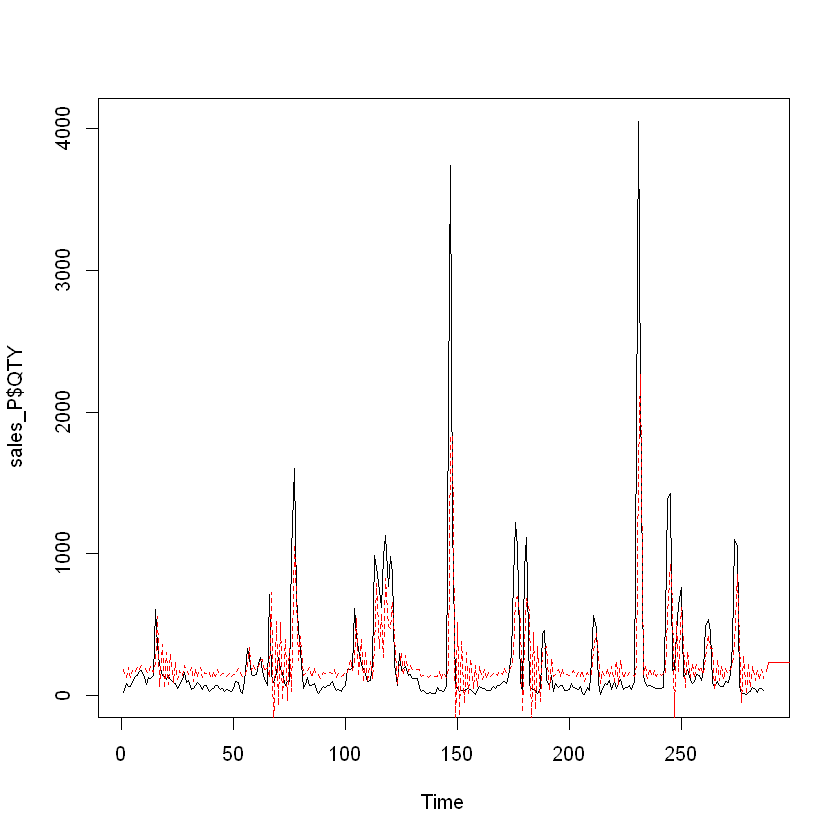

In [18]:
predict_MA<-predict(MA_Model,n.ahead = 30)
ts.plot(sales_P$QTY)
points(MA_fitted, type = "l", col = 2, lty = 2)
points(predict_MA$pred, type = "l", col = 2)

Comparando os dois modelos

Nesse caso, a média móvel parece levar a melhor sobre o modelo de autoregressão. Isso faz sentido tendo em vista que TN-1 é muito importante para a definir TN, mas TN-2 possui correlação consideravelmente inferior

In [19]:
cor(AR_fitted, MA_fitted)
paste("AIC_AR:",AIC(AR_Model))
paste("AIC_MA:",AIC(MA_Model))
paste("BIC_AR:",BIC(AR_Model))
paste("BIC_MA:",BIC(MA_Model))

[1] 0.827687

[1] "AIC_AR: 4188.79786228301"

[1] "AIC_MA: 4123.34272574705"

[1] "BIC_AR: 4199.77630893029"

[1] "BIC_MA: 4134.32117239433"